# Recurrent Net for Sentiment Classification

This RNN performs sentiment analysis on the IMDB review dataset.

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, SpatialDropout1D
from keras.layers import Embedding, SimpleRNN
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Set Hyperparameters

In [2]:
output_dir = 'model_output/rnn'

epochs = 5
batch_size = 128

n_dim = 64 
n_unique_words = 10000 
max_review_length = 100 # lowered due to vanishing gradient over time
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

n_rnn = 256 
drop_rnn = 0.2

#### Load Data

In [3]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

#### Preprocess Data

In [4]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design Deep Net Architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(SimpleRNN(n_rnn, dropout=drop_rnn, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 64)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 256)               82176     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 722,433
Trainable params: 722,433
Non-trainable params: 0
_________________________________________________________________


#### Configure the Model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5')

In [9]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train the Model

In [10]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.4)#, callbacks=[modelcheckpoint])

Train on 15000 samples, validate on 10000 samples
Epoch 1/5
15000/15000 [==============================] - 23s 2ms/step - loss: 0.6911 - acc: 0.5693 - val_loss: 0.7503 - val_acc: 0.5495
Epoch 2/5
15000/15000 [==============================] - 22s 1ms/step - loss: 0.5801 - acc: 0.6901 - val_loss: 0.5908 - val_acc: 0.6580
Epoch 3/5
15000/15000 [==============================] - 22s 1ms/step - loss: 0.4585 - acc: 0.7881 - val_loss: 0.4730 - val_acc: 0.7874
Epoch 4/5
15000/15000 [==============================] - 22s 1ms/step - loss: 0.3179 - acc: 0.8643 - val_loss: 0.4335 - val_acc: 0.8057
Epoch 5/5
15000/15000 [==============================] - 22s 1ms/step - loss: 0.2600 - acc: 0.8977 - val_loss: 0.4708 - val_acc: 0.7892


#### Evaluate

In [12]:
# This is zero-indexed. So, Epoch 4 corresponds to file weights.03.hdf5
# model.load_weights(output_dir+'/weights.03.hdf5')

In [13]:
y_hat = model.predict_proba(X_valid)

In [14]:
y_hat[0]

array([0.29386437], dtype=float32)

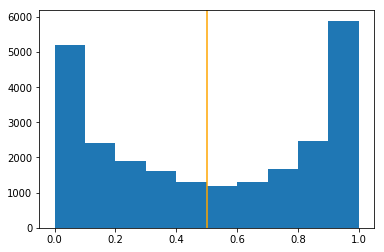

In [15]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [16]:
'''
    * Receive Operating Characteristic (ROC)
        * True Positive Rate
            * TPR = TP / (TP + TN)
        * False Positive Rate
            * FPR = FP / (FP + TN)
        * Plot the results of the TPR and FPR to get the Area Under the Curve (AUC).
'''
pct_auc = roc_auc_score(y_valid, y_hat) * 100

In [17]:
'{:0.2f}'.format(pct_auc)

'87.20'